# Spatio-temporal Transcriptomics

In [1]:
import torch
import numpy as np

from lafomo.variational.kernels import SpatioTemporalRBF
from lafomo.variational.models.partial import ReactionDiffusion
from lafomo.datasets import ToySpatialTranscriptomics, P53Data
from lafomo.configuration import VariationalConfiguration
from lafomo.utilities.torch import save, load
from lafomo.plot import Plotter

from matplotlib import pyplot as plt


In [2]:
# import pandas as pd
# data_in = dataset.data[0][0]
# data_out = dataset.data[0][1]


def plot_output(ax, output, title=None):
    ax.set_title(title)
    ax.plot(output)
    ax.set_xlabel('distance')
    ax.set_ylabel('y')
def scatter_output(ax, tx, output, title=None):
    ax.set_title(title)
    ax.scatter(tx[0], tx[1], c=output)
    ax.set_xlabel('time')
    ax.set_ylabel('distance')
    ax.set_aspect('equal')

config = VariationalConfiguration(
    initial_conditions=False,
    num_samples=16, learn_inducing=False
)

In [3]:
from torch.nn import Parameter
from lafomo.datasets import LFMDataset
from lafomo import LFM
from lafomo.variational.models import VariationalLFM


class PartialLFM(VariationalLFM):
    def __init__(self, num_latents: int, config: VariationalConfiguration, kernel, t_inducing,
                 dataset: LFMDataset, dtype=torch.float64):
        super().__init__(num_latents, config, kernel, t_inducing, dataset, dtype)
        if self.options.initial_conditions:
            raise Exception('Initial conditions are not implemented for PartialLFM.')

        T = 1.0            # final time
        self.time_steps = 40
        self.mesh_cells = 40
        self.fenics_module = ReactionDiffusion(T/self.time_steps, self.mesh_cells)
        self.sensitivity = Parameter(torch.ones((1, 1), dtype=torch.float64), requires_grad=False)
        self.decay = Parameter(0.1*torch.ones((1, 1), dtype=torch.float64), requires_grad=False)
        self.diffusion = Parameter(0.01*torch.ones((1, 1), dtype=torch.float64), requires_grad=False)

    def forward(self, tx, h, compute_var=False, return_samples=False):
        """
        tx : torch.Tensor
            Shape (2, num_times)
        h : torch.Tensor the initial state of the ODE
            Shape (num_genes, 1)
        Returns
        -------
        Returns evolved h across times t.
        Shape (num_genes, num_points).
        """
        self.nfe = 0

        # Precompute variables
        self.Kmm = self.kernel(self.inducing_inputs)
        self.L = torch.cholesky(self.Kmm)
        q_cholS = torch.tril(self.q_cholS)
        self.S = torch.matmul(q_cholS, torch.transpose(q_cholS, 1, 2))

        # Integrate forward from the initial positions h0.

        ####
        outputs = list()
        y_prev = torch.zeros((self.options.num_samples, self.mesh_cells + 1), requires_grad=False, dtype=torch.float64)
        t_index = 0
        q_u = self.get_latents(tx)
        print('mean', q_u.mean.shape)
        u = q_u.rsample([self.options.num_samples])
        u = self.G(u)  # (S, num_outputs, t)

        for n in range(self.time_steps + 1):
            # u = data[data['t'] == t[t_index]]['U'].values
            # u = torch.tensor(u, requires_grad=False).unsqueeze(0)

            u_n = u[:,0,t_index::41]  # (S, t)
            # plt.plot(u[0].detach())

            sensitivity = self.sensitivity.repeat(self.options.num_samples, 1)
            decay = self.decay.repeat(self.options.num_samples, 1)
            diffusion = self.diffusion.repeat(self.options.num_samples, 1)

            y_prev = self.fenics_module(y_prev, u_n,
                                        sensitivity, decay, diffusion)

            # y_prev shape (N, 21)
            t_index += 1
            outputs.append(y_prev)
        outputs = torch.stack(outputs).permute(1, 0, 2)
        f_mean = outputs.mean(dim=0).unsqueeze(0)  # shape (batch, times, distance)
        f_var = outputs.var(dim=0).unsqueeze(0)
        # print(f_mean.shape)
        return f_mean, f_var
        ####
        # h_samples = odeint(self.odefunc, h0, t, )  # (T, S, num_outputs, 1)
        #
        # if return_samples:
        #     return h_samples
        #
        # h_out = torch.mean(h_samples, dim=1).transpose(0, 1)
        # h_std = torch.std(h_samples, dim=1).transpose(0, 1)
        #
        # if compute_var:
        #     return self.decode(h_out), h_std
        # return self.decode(h_out)

    def G(self, u):
        return u

In [4]:

from lafomo.variational.trainer import Trainer
from lafomo.utilities.torch import is_cuda

class PDETrainer(Trainer):

    def single_epoch(self, *args):
        epoch_loss = 0
        epoch_ll = 0
        epoch_kl = 0
        for i, data in enumerate(self.data_loader):
            self.optimizer.zero_grad()
            tx, y_target = data
            tx = tx.cuda() if is_cuda() else tx
            y_target = y_target.cuda() if is_cuda() else y_target
            # Assume that the batch of t s are the same
            tx = tx[0]
            initial_value = self.initial_value(y_target)
            initial_value = None

            f_mean, f_var = self.model(tx, initial_value)

            print('f_mean shape', f_mean.shape, f_var.shape)
            f_mean = f_mean.transpose(1, 2).reshape(1, -1)
            f_var = f_var.transpose(1, 2).reshape(1, -1)
            print('f_mean shape', f_mean.shape, f_var.shape)
            # loss = self.loss_fn(y_prev, y_target)
            # loss.backward()
            fig, axes = plt.subplots(ncols=2)
            scatter_output(axes[0], tx, f_mean.detach(), 'Prediction')
            scatter_output(axes[1], tx, y_target, 'Actual')

            # Calc loss and backprop gradients
            mult = 1
            if self.num_epochs <= 10:
                mult = self.num_epochs/10

            ll, kl = self.model.elbo(y_target, f_mean, f_var, mult)
            total_loss = -ll + kl

            total_loss.backward()

            self.optimizer.step()

            epoch_loss += total_loss.item()
            epoch_ll += ll.item()
            epoch_kl += kl.item()

        return epoch_loss, (-epoch_ll, epoch_kl)

    def print_extra(self):
        print(' s:', model.sensitivity[0].item(),
              'dif:', model.diffusion[0].item(),
              'dec:', model.decay[0].item())


t_inducing = torch.linspace(0, 1, 40, dtype=torch.float64).view(1, -1).repeat(2, 1)

num_latents = 1
dataset = ToySpatialTranscriptomics(data_dir='../../../data/')

kernel = SpatioTemporalRBF(num_latents, initial_lengthscale=0.3)

model = PartialLFM(num_latents, config, kernel, t_inducing, dataset)
optimizer = torch.optim.Adam(model.parameters(), lr=0.07)
trainer = PDETrainer(model, optimizer, dataset)

torch.Size([1, 2])


/Users/jacob/Documents/proj/reggae/lafomo/variational/models/model.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.inducing_inputs = Parameter(torch.tensor(t_inducing), requires_grad=config.learn_inducing)


mean torch.Size([1, 1681])
f_mean shape torch.Size([1, 41, 41]) torch.Size([1, 41, 41])
f_mean shape torch.Size([1, 1681]) torch.Size([1, 1681])
sq_diff.max =  tensor(0.4145, dtype=torch.float64, grad_fn=<MaxBackward1>)
Epoch 121/140 - Loss: -4049.84 (-4234.65  184.80  ) λ: 0.00 0.00 s: 1.0 dif: 0.01 dec: 0.1
mean torch.Size([1, 1681])
f_mean shape torch.Size([1, 41, 41]) torch.Size([1, 41, 41])
f_mean shape torch.Size([1, 1681]) torch.Size([1, 1681])
sq_diff.max =  tensor(0.5386, dtype=torch.float64, grad_fn=<MaxBackward1>)
Epoch 122/140 - Loss: -3740.16 (-3909.13  168.97  ) λ: 0.00 0.00 s: 1.0 dif: 0.01 dec: 0.1
mean torch.Size([1, 1681])
f_mean shape torch.Size([1, 41, 41]) torch.Size([1, 41, 41])
f_mean shape torch.Size([1, 1681]) torch.Size([1, 1681])
sq_diff.max =  tensor(0.4924, dtype=torch.float64, grad_fn=<MaxBackward1>)
Epoch 123/140 - Loss: -3912.85 (-4072.00  159.14  ) λ: 0.00 0.00 s: 1.0 dif: 0.01 dec: 0.1
mean torch.Size([1, 1681])
f_mean shape torch.Size([1, 41, 41]) tor

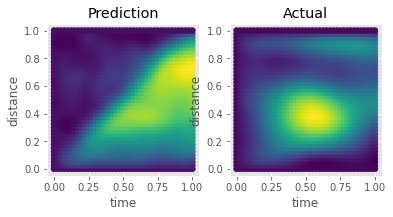

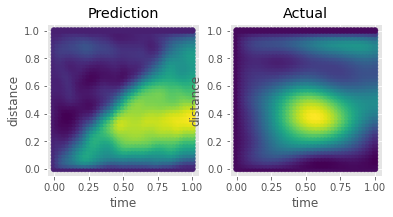

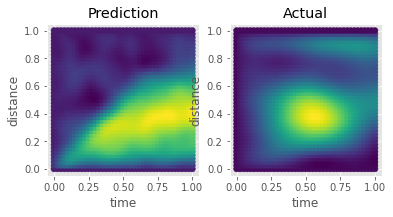

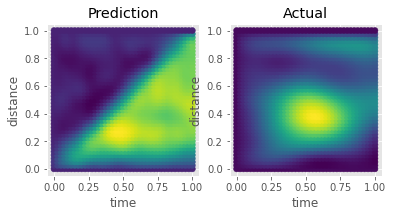

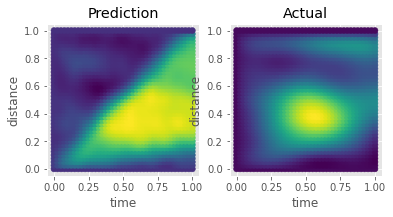

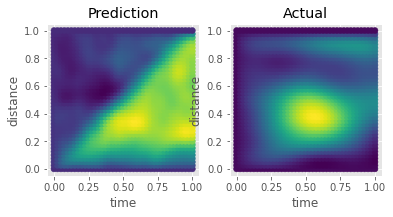

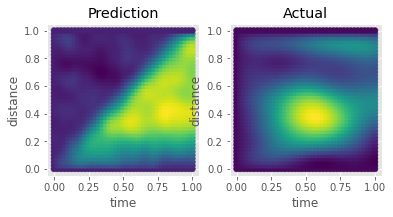

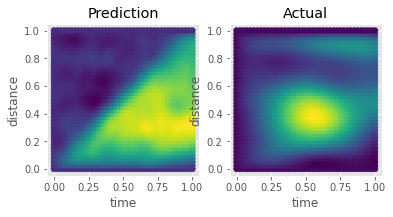

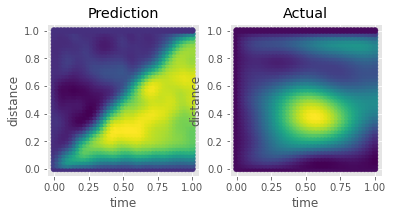

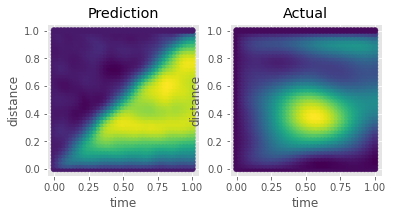

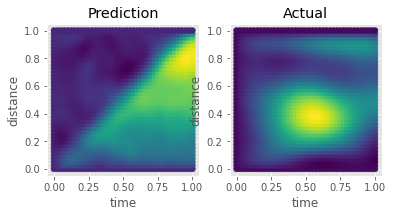

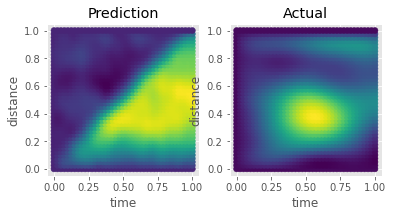

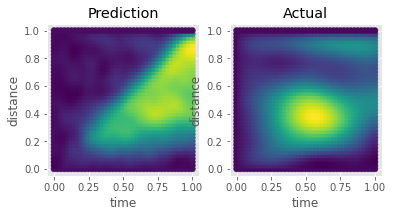

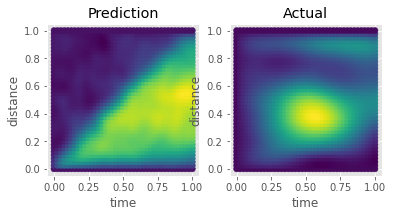

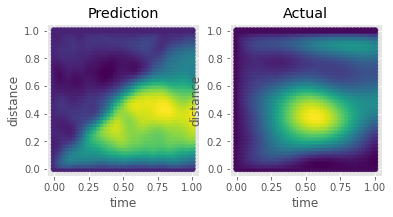

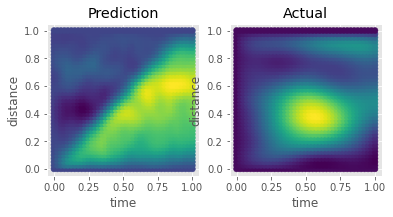

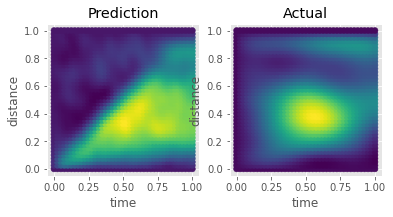

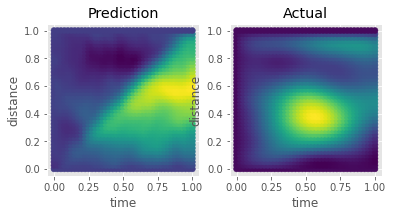

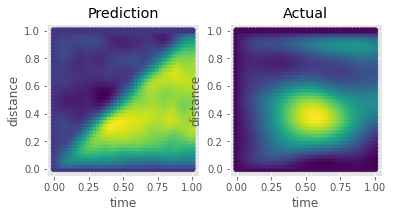

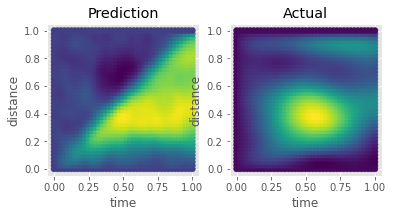

In [12]:
trainer.train(20)

In [77]:
# data = next(iter(dataset))
# tx, y_target = data
#
# q_u = model.get_latents(tx)
# plt.imshow(q_u.sample([1]).view(41, 41).detach())
# plt.figure()
# plt.imshow(q_u.sample([1]).view(41, 41).detach())

AttributeError: 'PartialLFM' object has no attribute 'L'

In [ ]:
initial_value = None
print(tx.shape)
f_mean, f_var = model(tx, initial_value)
plt.imshow(f_mean[0].detach())

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0250, 0.0500, 0.0750, 0.1000, 0.1250, 0.1500, 0.1750, 0.2000,
         0.2250, 0.2500, 0.2750, 0.3000, 0.3250, 0.3500, 0.3750, 0.4000, 0.4250,
         0.4500, 0.4750, 0.5000, 0.5250, 0.5500, 0.5750, 0.6000, 0.6250, 0.6500,
         0.6750, 0.7000, 0.7250, 0.7500, 0.7750, 0.8000, 0.8250, 0.8500, 0.8750,
         0.9000, 0.9250, 0.9500, 0.9750, 1.0000]], dtype=torch.float64)
torch.Size([2, 1681]) torch.Size([1681])
torch.Size([1, 1681, 1681])


<Figure size 432x288 with 0 Axes>

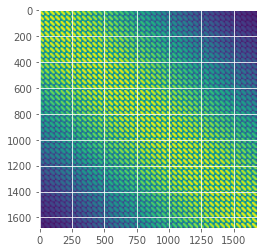

<Figure size 432x288 with 0 Axes>

In [56]:
print('f_mean shape', f_mean.shape, f_var.shape)
f_mean = f_mean.transpose(1, 2).reshape(1, -1)
f_var = f_var.transpose(1, 2).reshape(1, -1)
print('f_mean shape', f_mean.shape, f_var.shape)
# loss = self.loss_fn(y_prev, y_target)
# loss.backward()
fig, axes = plt.subplots(ncols=2)
scatter_output(axes[0], tx, f_mean.detach(), 'Prediction')
scatter_output(axes[1], tx, y_target, 'Actual')

In [10]:
plt.figure()
print(tx[0])
print(tx[:, 0::41])
print(dataset[0][0].shape, dataset[0][1].shape)
K = kernel(dataset[0][0])
print(K.shape)
plt.imshow(K[0].detach())

plt.figure()
# plt.imshow(dataset[0][1])



NameError: name 'tx' is not defined

<Figure size 432x288 with 0 Axes>

In [ ]:
print(model.kernel.lengthscale, model.sensitivity, model.diffusion)

In [ ]:
fig, axes = plt.subplots(ncols=2)
scatter_output(axes[0], us.transpose(1, 2).reshape(-1), 'Prediction')
scatter_output(axes[1], data.iloc[:, 3], 'Actual')

plt.tight_layout()
fig, axes = plt.subplots(ncols=2)
plot_output(axes[0], us[0, 4, :], 'Prediction')
plot_output(axes[1], data[data['t'] == ts[4]].iloc[:, 3], 'Actual')


In [ ]:
plt.plot(data[data['t'] == ts[5]].iloc[:, 2])
plt.xlabel('distance')
plt.ylabel('u')
